In [1]:
# !pip install -q segmentation_models_pytorch

In [1]:
# !nvidia-smi
# Tesla V100-SXM2-16GB Google Colab pro

In [2]:
# !lsb_release -a
# # No LSB modules are available.
# # Distributor ID:	Ubuntu
# # Description:	Ubuntu 22.04.3 LTS
# # Release:	22.04
# # Codename:	jammy

In [3]:
# !python --version
# # Python 3.10.12

In [4]:
# !pip3 show torch
# # Name: torch
# # Version: 2.1.0+cu121
# # Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
# # Home-page: https://pytorch.org/
# # Author: PyTorch Team
# # Author-email: packages@pytorch.org
# # License: BSD-3
# # Location: /usr/local/lib/python3.10/dist-packages
# # Requires: filelock, fsspec, jinja2, networkx, sympy, triton, typing-extensions
# # Required-by: fastai, torchaudio, torchdata, torchtext, torchvision

In [5]:
# !pip install imagecodecs

In [7]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import cv2
import tifffile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
import warnings
warnings.filterwarnings("ignore")

import random
import torch
import torch.nn as nn
import albumentations

# import segmentation_models_pytorch as smp
import skimage


from tqdm import tqdm
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader,Dataset
from fastprogress import master_bar, progress_bar

def create_dir(path):
    if os.path.isdir(path)==False:
        os.makedirs(path)

In [6]:
# # CONFIGURE 

# # Set Data Paths
# test_path='test_satellite/'
# train_path='train_satellite/'
# labels_path='train_kelp/'


# # Create directories
# # test_predmask_path='test_kelp/'
# # create_dir(test_predmask_path)

# # set weights directory for new training saving
# weights_path='weights/'
# create_dir(weights_path)


# RETRAIN= False # if true retrain else use trained weights for inference
# trained_weights = 'trained_weights/' # meaningful only when RETRAIN=False


# # directory for prediction probabilities 
# test_preds_dir = 'test_preds/'
# create_dir(test_preds_dir)

from config import test_path, train_path, labels_path, weights_path, RETRAIN, trained_weights, test_preds_dir

# DO NOT EDIT BELOW

In [7]:
test_path, train_path, labels_path, weights_path, RETRAIN, trained_weights, test_preds_dir

('test_satellite/',
 'train_satellite/',
 'train_kelp/',
 'weights/',
 False,
 'trained_weights/',
 'test_preds/')

In [9]:
basename='segm_GCp_v15full'


# training schedule variables
epochs=30
snapshots = 1
lr_0 = 0.00005
WARMUP_EPOCHS=0

# training input variables
SIZE=896 # resize image size
channels=[0,1,3] # SWIR, NIR, Green
meansCH = np.array( [0.485, 0.456, 0.406] )
stdsCH = np.array( [0.229, 0.224, 0.225] )
stdsCH *= 0.9
CLIPMIN=6000
CLIPMAX=24000


BA=3 # Batch Accumulation
num_workers = 4 # 
bs = 3 # Batch Size

In [10]:
test_image_names=os.listdir(test_path)
train_image_names=os.listdir(train_path)
mask_names = os.listdir(labels_path)
len(test_image_names),len(train_image_names),len(mask_names),test_image_names[0],mask_names[0]

(1426, 5635, 5635, 'FF979226_satellite.tif', 'WG210136_kelp.tif')

In [8]:
full_train_img_paths= np.array([train_path+x for x in train_image_names])
full_train_msk_paths= np.array([labels_path+x.split('_')[0]+'_kelp.tif' for x in train_image_names])
# full_test_img_paths= np.array([test_path+x for x in test_image_names])
# test_image_names=np.load('/kaggle/input/needkelp/kafe_test_image_names.npz')['arr_0']
full_test_img_paths=np.array([test_path+x for x in test_image_names])
len(full_train_img_paths),len(full_train_msk_paths),len(full_test_img_paths),full_train_img_paths[:2],full_test_img_paths[:2]


In [ ]:
# vids=np.load('/kaggle/input/needkelp/valid_imids_ph2.npz')['arr_0']
# tids=np.load('/kaggle/input/needkelp/train_imids_ph2.npz')['arr_0']
# len(tids),len(vids)

# train_ids= np.array([train_path+x for x in tids])
# val_ids= np.array([train_path+x for x in vids])
# train_ids.shape, val_ids.shape

# train_ids=np.concatenate((train_ids,val_ids))

train_ids=np.array([train_path+x for x in train_image_names])
train_ids.shape,train_ids[:3]

In [12]:
from transformers import SwinConfig, UperNetConfig, UperNetForSemanticSegmentation
ENCODER = 'UPNTcnvxtT'
model = UperNetForSemanticSegmentation.from_pretrained("openmmlab/upernet-convnext-tiny")
model.decode_head.classifier = torch.nn.Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))

config.json:   0%|          | 0.00/8.76k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

In [13]:
def cosine_anneal_schedule(t):
    cos_inner = np.pi * (t % (epochs // snapshots))
    cos_inner /= epochs // snapshots
    cos_out = np.cos(cos_inner) + 1
    return float(lr_0 / 2 * cos_out)
cosine_anneal_schedule_list=[cosine_anneal_schedule(x) for x in range(epochs)]
# cosine_anneal_schedule_list
# WARMUP_EPOCHS=2
# cosine_anneal_schedule_list=[0.000001]*WARMUP_EPOCHS+cosine_anneal_schedule_list
# epochs=len(cosine_anneal_schedule_list)
def adjust_optim(optimizer, n_iter):
    optimizer.param_groups[0]['lr'] = cosine_anneal_schedule_list[n_iter % epochs]

# adjust_optim(optimizer,47)

In [14]:

Ms = meansCH.mean()
Ss = stdsCH.mean()

RANDOM_ERASE_PROB=0.25
MAX_ERASE_DIM=0.1
RANDOM_ERASE_MAX_TIMES=5

class KelpDataset_disk(torch.utils.data.Dataset):
    """Reads in images, transforms pixel values, and serves a
    dictionary containing chip ids, image tensors, and
    label masks (where available).
    """

    def __init__(self, x_paths,y_paths, transforms=None, preprocessing=None, mode='train'):
        self.x_paths = x_paths
        self.y_paths = y_paths
        # self.ids = ids
        self.transforms = transforms
        self.preprocessing = preprocessing
        self.mode=mode

    def __len__(self):
        return len(self.x_paths)

    def __getitem__(self, idx):
        # Loads a 3-channel image from a chip-level dataframe
        # x_arr = images[idx].astype('float')
        # y_arr = masks[idx]
        x_arr=tifffile.imread(self.x_paths[idx]).astype('float32')
        t=x_arr.copy()
        x_arr=np.clip(x_arr,CLIPMIN,CLIPMAX)
        x_arr[t<=-32000]=0
        # del t

        if self.mode=='test':
            y_arr=np.zeros((350,350)).astype('uint8')
        else:
            y_arr=tifffile.imread(self.y_paths[idx])


        if self.mode=='train':
            if (random.random()<RANDOM_ERASE_PROB):
                RANDOM_ERASE_TIMES = np.random.choice(np.arange(1,RANDOM_ERASE_MAX_TIMES+1))
                for a in range(RANDOM_ERASE_TIMES):
                    ULc=(int(random.random()*x_arr.shape[0]),int(random.random()*x_arr.shape[1]))
                    EH = int(min(x_arr.shape[0]-ULc[0], random.random()*MAX_ERASE_DIM*x_arr.shape[0]))
                    EW = int(min(x_arr.shape[1]-ULc[1], random.random()*MAX_ERASE_DIM*x_arr.shape[1]))
                    x_arr[ULc[0]:ULc[0]+EH, ULc[1]:ULc[1]+EW,...] = CLIPMIN
                    x_arr[t<=-32000]=0
                    y_arr[ULc[0]:ULc[0]+EH, ULc[1]:ULc[1]+EW] = 0
        del t
        y_arr = np.expand_dims(y_arr, -1).astype('float32')

        # print(x_arr.shape,y_arr.shape)
        # Apply data augmentations, if provided
        if self.transforms:
            augmented = self.transforms(image=x_arr, mask=y_arr)
            x_arr, y_arr = augmented['image'], augmented['mask']
        # x_arr = np.transpose(x_arr, [2, 0, 1])



        x_arr = x_arr[...,channels]/CLIPMAX
        x_arr = (x_arr - meansCH)/stdsCH

        x_arr = np.transpose(x_arr, [2, 0, 1])
        y_arr = np.transpose(y_arr, [2, 0, 1])

        if self.preprocessing:
            preprocessed = self.preprocessing(image=x_arr, mask=y_arr)
            # preprocessed = self.preprocessing(image=x_arr)
            x_arr = preprocessed['image']
            y_arr = preprocessed['mask']

        return x_arr.astype('float32'), y_arr.astype('float32')#.astype('uint8')#, not_missing_mask.astype('uint8')

In [15]:

training_transformations = albumentations.Compose(
    [
        albumentations.Resize(SIZE, SIZE, interpolation=2),
        albumentations.RandomRotate90(),
        albumentations.HorizontalFlip(),
        albumentations.VerticalFlip(),
    ]
)
validation_transformations = albumentations.Compose(
    [
        albumentations.Resize(SIZE, SIZE, interpolation=2),
    ]
)

In [16]:
from sklearn.metrics import jaccard_score
def get_dice_coef(gt, preds, THRESH=0.5):
    #gt shape BxCxHxW
    #preds shape BxHxW
    dice = np.sum((preds>THRESH)[gt[:,0,...]==1])*2.0 / (np.sum((preds>THRESH)) + np.sum(gt[:,0,...]))
    return dice


class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, eps=1e-7):

        # #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection )/(inputs.sum() + targets.sum() + eps)

        return 1 - dice


In [17]:
# def adjust_optim(optimizer, n_iter):
#     optimizer.param_groups[0]['lr'] = cosine_anneal_schedule_list[n_iter % epochs]
#     optimizer.param_groups[1]['lr'] = cosine_anneal_schedule_list[n_iter % epochs]*10
#     optimizer.param_groups[2]['lr'] = cosine_anneal_schedule_list[n_iter % epochs]
# # adjust_optim(optimizer, 10)

In [18]:
name=ENCODER+'_'+basename
model.cuda()

if RETRAIN==True:
    optimizer = optim.AdamW(model.parameters(), lr=lr_0)
    # optimizer=optim.AdamW([
    #                 {'params': model.encoder.parameters()},
    #                 {'params': model.decoder.parameters(), 'lr': lr_0*5},
    #                 {'params': model.segmentation_head.parameters()}
    #             ], lr=lr_0, weight_decay=0.01)



    train_dataset = KelpDataset_disk(x_paths=train_ids,
                                     y_paths=[x.replace('satellite', 'kelp') for x in train_ids],
                                 transforms = training_transformations,
                                    )

    train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=num_workers, drop_last=True)


    criterion1 = DiceLoss()

    mb = master_bar(range(epochs))
    loss_log=[]
    for epoch in mb:
        avg_train_loss = 0.
        model.train()

        pb = progress_bar(train_loader)
        for ii, (data, target) in enumerate(pb):


            data, target = data.cuda(non_blocking=True), target.cuda(non_blocking=True)

            output = model(data)
            output = output.logits
            output = torch.sigmoid(output)
            loss = criterion1(output, target.to(dtype=torch.float))#.mean()
            loss.backward()
            if (ii + 1) % BA == 0:
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                # optimizer.zero_grad()
            if ii % 1000 == 0:
                loss_log.append(loss.item())
            avg_train_loss += loss.item() / len(train_loader)

        print('Epoch: {} - Loss: {:.6f}'.format(epoch + 1, avg_train_loss))

        adjust_optim(optimizer, (epoch + 1))

        gc.collect()

    torch.save(model.state_dict(), weights_path+name+'_last.pt')
else:
    model.load_state_dict(torch.load(  trained_weights+ENCODER+'_'+basename+'_last.pt') )       

In [19]:
model.eval()
print('model eval')

model eval


In [20]:
test_dataset = KelpDataset_disk(x_paths=full_test_img_paths,
                                y_paths=None,
                             transforms = validation_transformations,
                             # preprocessing=get_preprocessing(preprocessing_fn)
                                 mode='test'
                                )

test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False, num_workers=num_workers)


In [21]:
with torch.no_grad():

    test_preds1 =[]
    test_preds2 =[]
    test_preds3 =[]
    test_preds4 =[]


    pb = progress_bar(test_loader)
    for i, (x_batch, y_batch) in enumerate(pb):

        preds1 = torch.sigmoid(model(x_batch.cuda(non_blocking=True)).logits).detach()
        preds2 = torch.sigmoid(model(torch.flip(x_batch, dims=[2]).cuda(non_blocking=True)).logits).detach()
        preds3 = torch.sigmoid(model(torch.flip(x_batch, dims=[3]).cuda(non_blocking=True)).logits).detach()
        preds4 = torch.sigmoid(model(torch.flip(x_batch, dims=[2,3]).cuda(non_blocking=True)).logits).detach()

        test_preds1.append(preds1.cpu())
        test_preds2.append(preds2.cpu())
        test_preds3.append(preds3.cpu())
        test_preds4.append(preds4.cpu())
    test_preds1=np.vstack(test_preds1)[:,0,...]
    test_preds2=np.vstack(test_preds2)[:,0,...]
    test_preds3=np.vstack(test_preds3)[:,0,...]
    test_preds4=np.vstack(test_preds4)[:,0,...]

    # test_preds=(test_preds1+test_preds2[...,::-1,:]+test_preds3[...,:,::-1])/3
    test_preds=(test_preds1+test_preds2[...,::-1,:]+test_preds3[...,:,::-1]+test_preds4[...,::-1,::-1])/4

   

In [9]:
# test_preds = np.zeros((len(full_test_img_paths), SIZE,SIZE))
# with torch.no_grad():

#     counter=0
#     pb = progress_bar(test_loader)
#     for i, (x_batch, y_batch) in enumerate(pb):

#         preds1 = torch.sigmoid(model(x_batch.cuda(non_blocking=True)).logits).detach().cpu().numpy()
#         preds2 = torch.sigmoid(model(torch.flip(x_batch, dims=[2]).cuda(non_blocking=True)).logits).detach().cpu().numpy()
#         preds3 = torch.sigmoid(model(torch.flip(x_batch, dims=[3]).cuda(non_blocking=True)).logits).detach().cpu().numpy()
#         preds4 = torch.sigmoid(model(torch.flip(x_batch, dims=[2,3]).cuda(non_blocking=True)).logits).detach().cpu().numpy()


# #     test_preds=(test_preds1+test_preds2[...,::-1,:]+test_preds3[...,:,::-1]+test_preds4[...,::-1,::-1])/4
#         test_preds[counter*len(x_batch):(counter+1)*len(x_batch),...]=((preds1+preds2[...,::-1,:]+
#                                                         preds3[...,:,::-1]+preds4[...,::-1,::-1])/4)[:,0,...]
#         counter+=1


   

In [23]:
np.savez(test_preds_dir+basename[5:], test_preds.astype('float16'))

In [24]:
# test_preds.shape

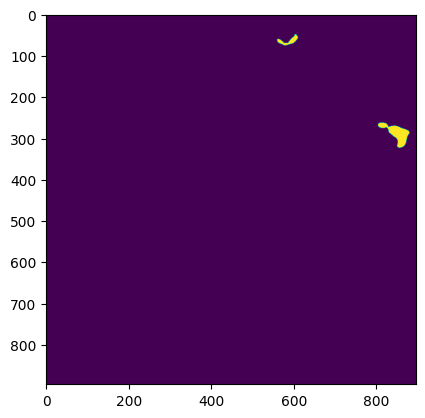

In [25]:
plt.imshow(test_preds[0]>0.5)
plt.show()

In [10]:
# test_preds = np.array([skimage.transform.resize(x, (350,350)) for x in test_preds])
# test_preds.shape

In [11]:
# THRESH=0.5
# test_preds = np.array([(x>THRESH).astype('uint8') for x in test_preds])

In [12]:
# [cv2.imwrite(test_predmask_path+test_image_names[i].split('_')[0]+'_kelp.tif', test_preds[i])
#  for i in range(len(test_preds))]
# print('saved in disk')

In [13]:
# # Remember to avoid including the inference dir itself
# !cd test_kelp && zip -rq subm_GC15full.zip *ip *

In [14]:
# !du -h subm_GC15full.zip

In [31]:
# !rm -r test_kelp